In [ ]:
!pip install -U pyvo
!pip install PyAstronomy
!pip install -U --pre astroquery[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.0/775.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 10.1 MB/s eta 0:00:00
  Created wheel for PyAstronomy: filename=PyAstronomy-0.21.0-py3-none-any.whl size=551636 sha256=e878b81af025f11da3ece6d25c2d6bbd09aadbaad1222d511549c2d5d1f433f5
  Stored in directory: /root/.cache/pip/wheels/af/0d/17/fd077134497d5853ed7e740e10f9b9a2b7712f4468911d6a07
Successfully built PyAstronomy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.2/911.2 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 39.9 MB/s eta 0:00:00
  

In [ ]:
# Required packages
import numpy as np
import astropy.io.fits as fits
from astropy.wcs import WCS
import astropy.coordinates as coord
from astropy import units as u

from PyAstronomy import pyasl

from astroquery.casda import Casda
from astroquery.utils.tap.core import TapPlus
from astroquery.utils.tap.core import Tap

import pyvo as vo
from pyvo.dal import sia
from pyvo.registry.rtcons import build_regtap_query

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec

# I think I got them all...


In [ ]:
#This is where you log in with your CASDA account
casda = Casda()
casda.login(username='YOUR EMAIL HERE')  # Replace with your casda account


22110114@student.westernsydney.edu.au, enter your password:
··········


INFO:astroquery:Authenticating 22110114@student.westernsydney.edu.au on CASDA ...


INFO: Authenticating 22110114@student.westernsydney.edu.au on CASDA ... [astroquery.casda.core]


INFO:astroquery:Authentication successful!


INFO: Authentication successful! [astroquery.casda.core]


In [ ]:
# Functions needed for EMU_CUTOUT
def percentage_nan(arr):
    total_elements = arr.size
    nan_count = np.count_nonzero(np.isnan(arr))
    return (nan_count / total_elements) * 100

def find_good_url(url_list, threshold):
    good_url = None

    for url in url_list:
        # Load the FITS image
        hdu_list = fits.open(url)
        image_data = hdu_list[0].data
        hdu_list.close()

        # Calculate the percentage of NaN values
        nan_percentage = percentage_nan(image_data)

        if nan_percentage < threshold:
            print(f"Image {url} has {nan_percentage:.2f}% NaN values and is acceptable for processing.")
            good_url = url
            break
        else:
            print(f"Image {url} has {nan_percentage:.2f}% NaN values and is not suitable for processing. Skipping...")

    return good_url

def EMU_CUTOUT(coordinates, search_radius): # Queries casda database for EMU data

  #set TAP to the CASDA service
  casdatap = TapPlus(url='https://casda.csiro.au/casda_vo_tools/tap')

  #need to set the following to the centre coords
  ra, dec = pyasl.coordsSexaToDeg(coordinates)
  centre = coord.SkyCoord(ra, dec, unit="deg")

  #Query against EMU
  query = "select * from ivoa.obscore where ( obs_collection = 'EMU' AND dataproduct_subtype = 'cont.restored.t0' and pol_states = '/I/'AND 1 = CONTAINS(POINT('ICRS',"+ str(ra) + ","+ str(dec) +"),s_region))"

  #do ADQL command on obscore to return list of images
  job = casdatap.launch_job_async(query)
  r = job.get_results()
  #may return more than one tile that contains the position

  #make cutout
  url_list = casda.cutout(r, coordinates=centre, radius=(search_radius/2)*u.degree)

  # filter out checksum urls
  filtered_url_list = [url for url in url_list if not url.endswith('.checksum')]

  # Threshold for acceptable percentage of NaN values
  threshold = 10  #i.e if the image has more than 10% NaN pixels

  # Find the first acceptable image
  selected_url = find_good_url(filtered_url_list, threshold)

  if selected_url:
      print(f"Selected image for processing: {selected_url}")

      EMU = fits.open(selected_url)
      EMU_header = EMU[0].header
      EMU_data = EMU[0].data
      EMU_data1 = EMU_data[0,0,:,:]
      EMU_wcs = WCS(EMU_header[32:42])

      return EMU_data1,EMU_wcs

  else:
      print("No acceptable image found.")

In [ ]:
def WISE_CUTOUT(coordinates, size): # Query IRSA for WISE data
    # Setting up auto infrared

    # Obtain degree representation
    ra, dec = pyasl.coordsSexaToDeg(coordinates)

    # print(ra,dec)

    # Setting up to query allwise data
    ir_services = vo.regsearch(servicetype='image', waveband='Infrared', keywords=['wise'])
    ir_services.to_table()['ivoid', 'short_name', 'res_title']  # This line shows all of the catalogs for the query

    ir_im_table = ir_services[6].search(pos=(ra,dec),size=size,naxis=2000,format='all')
    # ir_im_table.to_table()

    surveys = ir_im_table['Survey'].tolist()

    # Filter the list to include only entries for the W1 band, can change this for different bands
    w1_band_entries = [entry for entry in surveys if 'w1' in str(entry)]
    # w1_band_entries

    w1_fits_urls = []

    # Loop through the filtered entries and extract the FITS file URLs
    for entry in w1_band_entries:
        index = surveys.index(entry)  # Find the index of the current entry in the original list
        fits_url = ir_im_table[index].getdataurl()  # Get the corresponding FITS file URL
        w1_fits_urls.append(fits_url)

  # Attempt to open the FITS file
    for fits_url in w1_fits_urls:
        try:
            ir_hdu_list = fits.open(fits_url, ignore_missing_simple=True)
            ir_hdu_list.info()
            ir_header = ir_hdu_list[0].header
            ir_data = ir_hdu_list[0].data
            ir_wcs = WCS(header=ir_header)

            # If we reach this point, the FITS file was successfully opened
            return ir_data, ir_wcs

        except Exception as e:
            print(f"Error opening FITS file: {e}")
            continue

    # If none of the FITS files could be opened, return None
    return None, None

In [ ]:
def DSS_CUTOUT(coords,size): # Query for the DSS database
  # Setting up auto optical

  # Obtain degree representation
  ra, dec = pyasl.coordsSexaToDeg(coords)

  op_services = vo.regsearch(servicetype='image',waveband='Optical',keywords=['dss'])
  op_services.to_table()['ivoid','short_name','res_title']

  op_im_table = op_services[0].search(pos=(ra,dec),size=size,naxis=2000,format='image/fits') #size is in units of square degrees
  op_im_table.to_table()

  for entry in op_im_table:
          try:
              fits_url = entry.getdataurl()
              # there is a red and a blue image, I just grabbed the red one
              red = fits.open(fits_url)
              red_data = red[0].data
              wcs = WCS(red[0].header)

              # If we reach this point, the FITS file was successfully opened
              return red_data, wcs

          except Exception as e:
              print(f"Error opening FITS file: {e}")
              continue

      # If none of the FITS files could be opened, return None
  return None, None

In [ ]:
def SUPER_PLOTTER(radio_img,radio_wcs,ir_img,ir_wcs,op_img,op_wcs): # Some code to plot
  fig = plt.figure(figsize=(20, 12))
  gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1])

  axs1 = fig.add_subplot(gs[0],projection = radio_wcs)
  axs1.imshow(radio_img,vmin = np.percentile(radio_img,25),vmax = np.percentile(radio_img,99.5),origin='lower',cmap='inferno')
  axs1.set_title('Radio Image',fontsize='xx-large')
  axs1.set_xlabel('RA',fontsize='x-large')
  axs1.set_ylabel('DEC',fontsize='x-large')

  # Setting up contour levels
 # lower_bound = np.percentile(radio_img,90)
 # upper_bound = np.percentile(radio_img, 99.5)
  #levels = np.linspace(lower_bound, upper_bound, 5)

  lower_bound = np.percentile(radio_img,95) # changing it to 95 , instead of 90 for clear contours
  upper_bound = np.percentile(radio_img, 99.5)
  levels = np.linspace(lower_bound, upper_bound, 5)


  axs2 = fig.add_subplot(gs[1], projection = ir_wcs)
  axs2.imshow(ir_img,cmap='inferno',vmin = np.percentile(ir_img,5),vmax = np.percentile(ir_img,99.5))#vmin=np.percentile(ir_img,1),vmax=np.percentile(op_img,99.5))#,origin='lower')
  axs2.contour(radio_img,colors='r',transform = axs2.get_transform(radio_wcs),levels=levels)
  axs2.set_title('Radio Contour on Infrared Image', fontsize = 'xx-large')
  axs2.set_xlabel('RA',fontsize='x-large')
  axs2.set_ylabel('DEC',fontsize='x-large')

  axs3 = fig.add_subplot(gs[2], projection = op_wcs)
  axs3.imshow(op_img,cmap='inferno',vmin = np.percentile(op_img,5),vmax = np.percentile(op_img,99.5))#vmin=np.percentile(op_img,1),vmax=np.percentile(op_img,99.5))#,origin='lower')
  axs3.contour(radio_img,colors='r',transform = axs3.get_transform(radio_wcs),levels=levels)
  axs3.set_title('Radio Contour on Optical Image', fontsize = 'xx-large')
  axs3.set_xlabel('RA',fontsize='x-large')
  axs3.set_ylabel('DEC',fontsize='x-large')

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


Image https://casda.csiro.au/download/web/781fe67a-4ff4-43dc-a71a-3132117b0988/cutout-649179-imagecube-179479.fits has 0.00% NaN values and is acceptable for processing.
Selected image for processing: https://casda.csiro.au/download/web/781fe67a-4ff4-43dc-a71a-3132117b0988/cutout-649179-imagecube-179479.fits
Filename: /root/.astropy/cache/download/url/66217f3b49324ad30393b280850bb8e9/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     122   (2000, 2000)   float32   


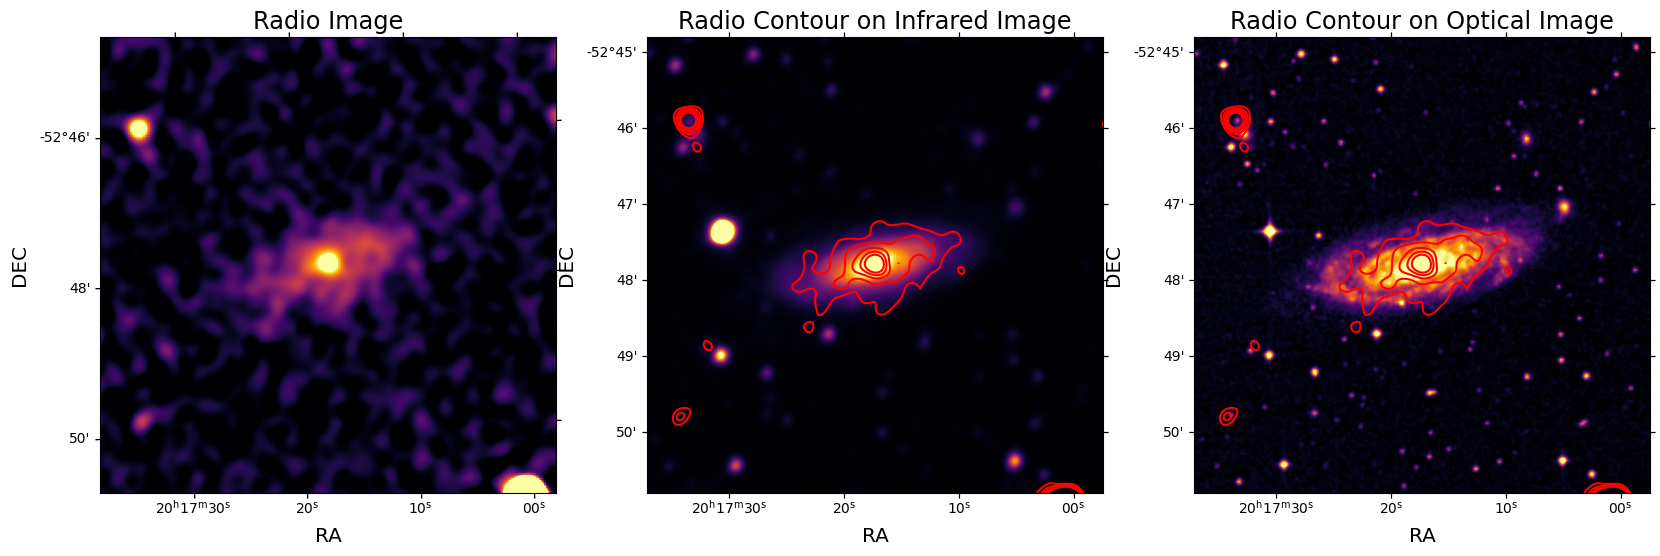

In [ ]:
# Some example code for plotting - FYI it does take a bit of time to run, so might be tedius for a large sample
# NGC 6887
coords = '20 17 17.3 -52 47 48' # Coordinates need to be in sexagesimal format

#size = 0.25 # this is in degrees, I found most radio galaxies fit into this size
size = 0.10
# Get images:
radio, radio_wcs = EMU_CUTOUT(coords,size)

ir, ir_wcs = WISE_CUTOUT(coords,size)

op, op_wcs = DSS_CUTOUT(coords,size)

# Make the plot
SUPER_PLOTTER(radio, radio_wcs, ir, ir_wcs, op, op_wcs)
# plt.show()

Potential opportunities:

1. Read the coordinates from the Download NED file
2. Convert coordinates into sexa decimal
3. Run in the background to get 50  resolved at a time
4. Identify Size and flux density
5. https://gist.github.com/Sunmish/198ef88e1815d9ba66c0f3ef3b18f74c
